### 데이터 준비와 확인

In [ ]:
#$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
#$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
#$ mv ratings_*.txt ~/aiffel/sentiment_classification

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터 로더 구성

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)


    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    - 사전word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 모델구성을 위한 데이터 분석 및 가공

#### 데이터셋 내 문장 길이 분포

In [5]:
print(X_train[0])  # 1번째 리뷰데이터
print(X_train[1])  # 2번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('라벨: ', y_train[1])  # 2번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
라벨:  0
라벨:  1
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


#### 적절한 최대 문장 길이 지정

In [8]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(round(np.sum(num_tokens < max_tokens) / len(num_tokens)*100, 2) ))


pad_sequences maxlen :  41
전체 문장의 93.43%가 maxlen 설정값 이내에 포함됩니다. 


#### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)


In [10]:
# 문장길이의 평균값, 최대값, 표준편차를 다시 계산해본다.
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  41.0
문장길이 최대 :  41
문장길이 표준편차 :  0.0


### 모델구성 및 validation set 구성

#### 1-D Convolutional Neural Network(1-D CNN) 모델

In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

Cnn_model = keras.Sequential()
Cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
Cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Cnn_model.add(keras.layers.MaxPooling1D(5))
Cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Cnn_model.add(keras.layers.GlobalMaxPooling1D())
Cnn_model.add(keras.layers.Dense(8, activation='relu'))
Cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

Cnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

#### Embed 모델

##### Google의 Word2Vec 모델을 가져와 적용

In [13]:
from gensim.models import KeyedVectors
import os
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
vector = word2vec['love']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 0.10302734, -0.15234375,  0.02587891,  0.16503906, -0.16503906,
        0.06689453,  0.29296875, -0.26367188, -0.140625  ,  0.20117188,
       -0.02624512, -0.08203125, -0.02770996, -0.04394531, -0.23535156,
        0.16992188,  0.12890625,  0.15722656,  0.00756836, -0.06982422,
       -0.03857422,  0.07958984,  0.22949219, -0.14355469,  0.16796875,
       -0.03515625,  0.05517578,  0.10693359,  0.11181641, -0.16308594,
       -0.11181641,  0.13964844,  0.01556396,  0.12792969,  0.15429688,
        0.07714844,  0.26171875,  0.08642578, -0.02514648,  0.33398438,
        0.18652344, -0.20996094,  0.07080078,  0.02600098, -0.10644531,
       -0.10253906,  0.12304688,  0.04711914,  0.02209473,  0.05834961,
       -0.10986328,  0.14941406, -0.10693359,  0.01556396,  0.08984375,
        0.11230469, -0.04370117, -0.11376953, -0.0037384 , -0.01818848,
        0.24316406,  0.08447266, -0.07080078,  0.18066406,  0.03515625,
       -0.09667969, -0.21972656, -0.00328064, -0.03198242,  0.18

##### embeddin_matrix 생성

In [14]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [15]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
Embed_model = keras.Sequential()
Embed_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
Embed_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Embed_model.add(keras.layers.MaxPooling1D(5))
Embed_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
Embed_model.add(keras.layers.GlobalMaxPooling1D())
Embed_model.add(keras.layers.Dense(8, activation='relu'))
Embed_model.add(keras.layers.Dense(1, activation='sigmoid')) 

Embed_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### validation set 구성

In [16]:
# 3:2의 비율로 train 과 valid 데이터를 나눠줍니다.
# validation set 60000건 분리
X_val = X_train[:60000]   
y_val = y_train[:60000]

# validation set을 제외한 나머지 86182건
partial_X_train = X_train[60000:]  
partial_y_train = y_train[60000:]

print(X_train.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(146182, 41)
(86182, 41)
(86182,)
(60000, 41)
(60000,)


### 모델 훈련 개시

#### 1D CNN 모델 훈련

In [18]:
Cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Cnn_history = Cnn_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0291 - accuracy: 0.9923 - val_loss: 0.9745 - val_accuracy: 0.8126
Epoch 2/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0250 - accuracy: 0.9931 - val_loss: 1.0531 - val_accuracy: 0.8116
Epoch 3/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0233 - accuracy: 0.9936 - val_loss: 1.0933 - val_accuracy: 0.8129
Epoch 4/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0200 - accuracy: 0.9943 - val_loss: 1.1614 - val_accuracy: 0.8105
Epoch 5/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0212 - accuracy: 0.9939 - val_loss: 1.1937 - val_accuracy: 0.8113
Epoch 6/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 1.1985 - val_accuracy: 0.8083
Epoch 7/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0190 - accuracy: 0.9947 - val_loss: 1.2821 - val_accuracy: 0.8094
Epoch 

In [19]:
results = Cnn_model.evaluate(X_test,  y_test, verbose=2)

print(results)


1537/1537 - 0s - loss: 1.6311 - accuracy: 0.7994
[1.6311062574386597, 0.7993978261947632]


#### Embed 모델 훈련

In [20]:
Embed_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

Embed_history = Embed_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
169/169 [==============================] - 13s 77ms/step - loss: 0.7005 - accuracy: 0.5033 - val_loss: 0.6928 - val_accuracy: 0.5089
Epoch 2/20
169/169 [==============================] - 14s 81ms/step - loss: 0.6912 - accuracy: 0.5256 - val_loss: 0.6227 - val_accuracy: 0.7328
Epoch 3/20
169/169 [==============================] - 13s 77ms/step - loss: 0.5025 - accuracy: 0.7728 - val_loss: 0.4197 - val_accuracy: 0.8135
Epoch 4/20
169/169 [==============================] - 13s 76ms/step - loss: 0.3407 - accuracy: 0.8560 - val_loss: 0.3800 - val_accuracy: 0.8354
Epoch 5/20
169/169 [==============================] - 13s 79ms/step - loss: 0.2948 - accuracy: 0.8801 - val_loss: 0.3950 - val_accuracy: 0.8293
Epoch 6/20
169/169 [==============================] - 13s 77ms/step - loss: 0.2615 - accuracy: 0.8961 - val_loss: 0.3793 - val_accuracy: 0.8361
Epoch 7/20
169/169 [==============================] - 13s 78ms/step - loss: 0.2306 - accuracy: 0.9109 - val_loss: 0.3900 - val_accuracy:

In [21]:
results = Embed_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.7664 - accuracy: 0.8099
[0.7663635611534119, 0.8098948001861572]


### Loss, Accuracy 그래프 시각화

#### 1D CNN model 그래프 시각화

In [23]:
Cnn_history_dict = Cnn_history.history
print(Cnn_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


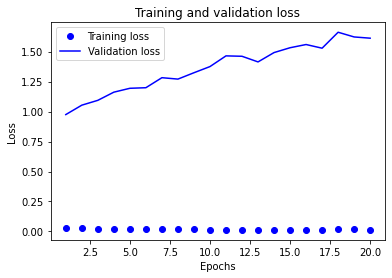

In [24]:
import matplotlib.pyplot as plt

acc = Cnn_history_dict['accuracy']
val_acc = Cnn_history_dict['val_accuracy']
loss = Cnn_history_dict['loss']
val_loss = Cnn_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Training loss는 지속적으로 줄어들지만, Validation loss는 급격하게 상승하고 있습니다.

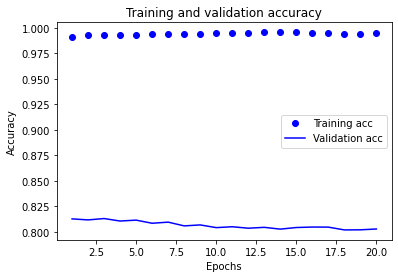

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



정확도의 측면에서 보니 모델 성능이 안좋은 모습을 더욱 확실하게 볼 수 있습니다.

#### Embed model 그래프 시각화

In [26]:
Embed_history_dict = Embed_history.history
print(Embed_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


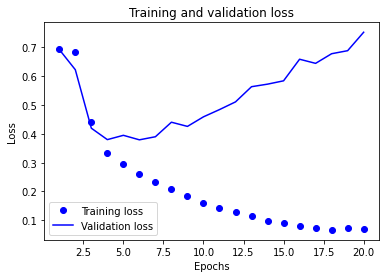

In [27]:
acc = Embed_history_dict['accuracy']
val_acc = Embed_history_dict['val_accuracy']
loss = Embed_history_dict['loss']
val_loss = Embed_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


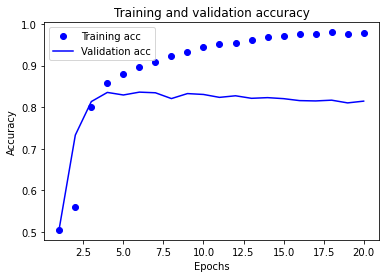

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 학습된 Embedding 레이어 분석

In [29]:
embedding_layer = Cnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [30]:
embedding_layer = Embed_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


#### 학습 파라미터 저장

In [39]:
import os
word_vector_dim = 16
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
Rnn_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/rnn_word2vec.txt'
f = open(Rnn_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = Cnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))

In [40]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word_vector_dim = 300
Embed_word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/Embed_word2vec.txt'
f = open(Embed_word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = Embed_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


#### 임베딩 파라미터 확인

In [43]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(Embed_word2vec_file_path, binary=False)
word_vectors.similar_by_word("love")


[('good', 0.7470753788948059),
 ('Good', 0.6885235905647278),
 ('♡', 0.6646206378936768),
 ('great', 0.6622002720832825),
 ('I', 0.6017481684684753),
 ('very', 0.6009340286254883),
 ('top', 0.5837702751159668),
 ('It', 0.5748971700668335),
 ('♥', 0.5588021278381348),
 ('best', 0.536775529384613)]

### 한국어 Word2Vec임베딩 활용하여 성능개선

#### 한국어 Word2Vec 모델을 가져와 적용

In [44]:
import os
import gensim
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['강아지']
vector

/home/aiffel/Downloads/ls/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 0.28099054, -0.19049376,  0.31788886, -0.29404902, -0.6012117 ,
       -0.25619242,  0.0061479 ,  0.51780385,  0.3608627 , -0.27890292,
        0.3753059 ,  0.45682365,  0.25841945,  0.29509434,  0.31509322,
        0.53255475, -0.3150408 ,  0.28672394,  0.32292762, -0.11534653,
        0.24962434, -0.31804952,  0.02379435,  0.34782323, -0.5428502 ,
       -0.31428298,  0.81061304,  0.7245631 ,  0.04309795, -1.0204421 ,
        0.10398801,  0.2138965 ,  0.10057439, -0.03146021,  0.0894748 ,
       -0.40986905,  0.11873247,  0.2684793 , -0.6372648 ,  0.36586553,
       -0.15963972,  0.3209763 , -0.6995127 , -1.1059827 ,  0.37646636,
       -0.82615834,  0.12098166, -0.04935855, -0.5623957 ,  0.1068015 ,
        0.2640723 ,  0.6015352 ,  0.31571352, -0.37577182, -0.5941042 ,
        0.1046523 , -0.16794747,  0.36965755,  0.18888052, -0.18799411,
        0.13297085,  0.13900231, -0.25006363, -0.7406368 ,  0.1037019 ,
       -0.18334036, -0.17581826,  0.08528292, -0.07013045,  0.45

In [45]:
word2vec.similar_by_word("사랑")

/home/aiffel/Downloads/ls/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [46]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]


/home/aiffel/Downloads/ls/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/Downloads/ls/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


#### 모델 구성

In [47]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
LSTM_UNITS = 196
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS

# 모델 구성
kor_model = keras.Sequential()
kor_model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
kor_model.add(keras.layers.SpatialDropout1D(0.4))
kor_model.add(keras.layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
kor_model.add(keras.layers.LSTM(LSTM_UNITS, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))  
kor_model.add(keras.layers.MaxPooling1D())
kor_model.add(keras.layers.GlobalMaxPooling1D())
kor_model.add(keras.layers.Dense(DENSE_HIDDEN_UNITS, activation='relu'))
kor_model.add(keras.layers.Dense(DENSE_HIDDEN_UNITS, activation='relu'))

kor_model.add(keras.layers.Dense(1, activation='sigmoid')) 

kor_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 41, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 41, 196)           311248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 41, 196)           308112    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 196)           0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 196)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

#### 모델 훈련 개시

In [48]:
callbacks = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

kor_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

kor_history = kor_model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
337/337 [==============================] - 102s 294ms/step - loss: 0.6077 - accuracy: 0.6390 - val_loss: 0.4198 - val_accuracy: 0.8027
Epoch 2/10
337/337 [==============================] - 102s 302ms/step - loss: 0.4390 - accuracy: 0.7905 - val_loss: 0.3570 - val_accuracy: 0.8396
Epoch 3/10
337/337 [==============================] - 98s 290ms/step - loss: 0.3722 - accuracy: 0.8313 - val_loss: 0.3487 - val_accuracy: 0.8475
Epoch 4/10
337/337 [==============================] - 98s 290ms/step - loss: 0.3470 - accuracy: 0.8432 - val_loss: 0.3337 - val_accuracy: 0.8533
Epoch 5/10
337/337 [==============================] - 100s 297ms/step - loss: 0.3240 - accuracy: 0.8572 - val_loss: 0.3358 - val_accuracy: 0.8557
Epoch 6/10
337/337 [==============================] - 99s 294ms/step - loss: 0.3099 - accuracy: 0.8634 - val_loss: 0.3306 - val_accuracy: 0.8591
Epoch 7/10
337/337 [==============================] - 99s 293ms/step - loss: 0.2936 - accuracy: 0.8701 - val_loss: 0.3359 - val

In [49]:
results = kor_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 25s - loss: 0.3376 - accuracy: 0.8575
[0.33761119842529297, 0.857538104057312]


#### Loss, Accuracy 그래프 시각화

In [50]:
kor_history_dict = kor_history.history
print(kor_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


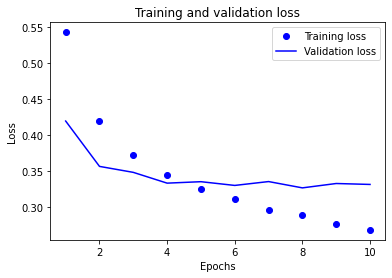

In [51]:
acc = kor_history_dict['accuracy']
val_acc = kor_history_dict['val_accuracy']
loss = kor_history_dict['loss']
val_loss = kor_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

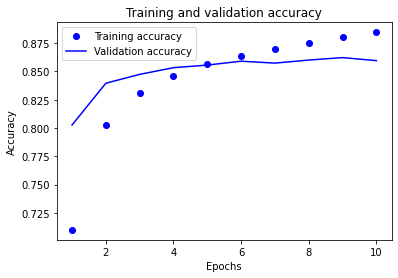

In [53]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### 느낀점(회고)
- 1D CNN Model의 Test Accuracy: 0.7994
- Google Embedding Model의 Test Accuracy: 0.8099
- Kor Embedding Model의 Test Accuracy: 0.8575
LSTM을 2개 사용하고 spatialDropout1D를 추가하고, LSTM안에 dropout과 recurrent_dropout을 추가했더니 성능이 더욱 오른 모습을 볼 수 있었습니다.